In [47]:
import gdown
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score


In [48]:
#loading our dataset
def download_data(url, output):
    gdown.download(url, output, quiet=False)

# Google Drive link for the merged_data.csv
file_url = "https://drive.google.com/file/d/1Oa62mOYcNhQEycOxyBFyrPkSfScA20zn/view?usp=sharing"
file_output = "merged_data.csv"  # Corrected: Assign the filename as a string

# Convert to a direct download link
file_id = file_url.split('/d/')[1].split('/view')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

# Check if the file already exists
if not os.path.isfile(file_output):
    print(f"Downloading {file_output}...")
    download_data(download_url, file_output)
else:
    print(f"{file_output} already exists. Skipping download.")

print("All datasets processed.")

merged_data.csv already exists. Skipping download.
All datasets processed.


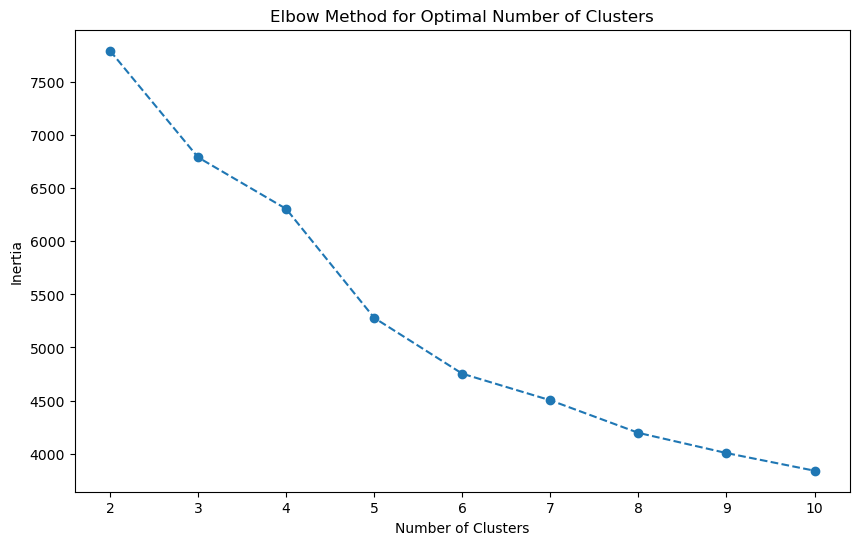

K-Means Clustering Results:
Number of Clusters: 5
Davies-Bouldin Index: 1.486408692756587
Silhouette Score: 0.1732435039719036
Calinski-Harabasz Index: 222.42986517780616


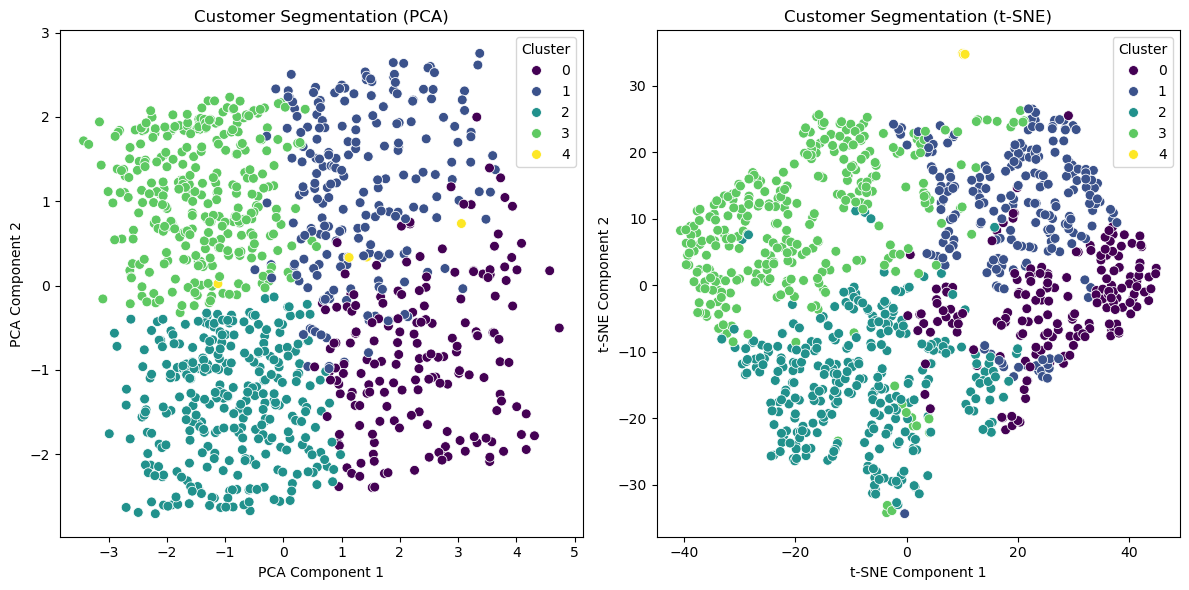

K-Means clustering results saved to 'Customer_Segmentation_KMeans.csv'

Davies-Bouldin Index for Different Algorithms:
GMM: 3.4682027887093207
Agglomerative: 1.5412831872807828
Spectral: 0.9836258982209822

Best algorithm based on Davies-Bouldin Index: Spectral
Best clustering results saved to 'Customer_Segmentation_Spectral.csv'


In [49]:
# Suppress unnecessary warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load dataset
merged_data = pd.read_csv('merged_data.csv')

# Feature Engineering
# Create new features: Recency, Frequency, Monetary Value
merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
latest_date = merged_data['TransactionDate'].max()
merged_data['Recency'] = (latest_date - merged_data['TransactionDate']).dt.days
frequency_data = merged_data.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency_data.rename(columns={'TransactionID': 'Frequency'}, inplace=True)
merged_data = merged_data.merge(frequency_data, on='CustomerID', how='left')
merged_data['MonetaryValue'] = merged_data['TotalValue']

# Select relevant features for clustering
features = [
    'Quantity', 'TotalValue', 'AvgPricePerItem', 'CustomerLifetimeValue',
    'TransactionYear', 'TransactionMonth', 'TransactionDay',
    'Recency', 'Frequency', 'MonetaryValue'
]

# Data preprocessing: Ensure numerical values only
clustering_data = merged_data[features].fillna(0)

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_data)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Apply KMeans Clustering with the optimal number of clusters
n_clusters = 5  # Adjust based on the Elbow Method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(normalized_data)

# Add cluster labels to the original data
merged_data['Cluster'] = clusters

# Calculate Clustering Metrics for K-Means
db_index = davies_bouldin_score(normalized_data, clusters)
silhouette_avg = silhouette_score(normalized_data, clusters)
calinski_harabasz = calinski_harabasz_score(normalized_data, clusters)

# Print Metrics for K-Means
print("K-Means Clustering Results:")
print(f"Number of Clusters: {n_clusters}")
print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(normalized_data)

# Visualization of Clusters using PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=pca_data[:, 0], y=pca_data[:, 1], 
    hue=clusters, palette="viridis", s=50
)
plt.title("Customer Segmentation (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")

# Visualization of Clusters using t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=tsne_data[:, 0], y=tsne_data[:, 1], 
    hue=clusters, palette="viridis", s=50
)
plt.title("Customer Segmentation (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")

plt.tight_layout()
plt.show()

# Save K-Means results to CSV
merged_data[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation_KMeans.csv', index=False)
print("K-Means clustering results saved to 'Customer_Segmentation_KMeans.csv'")

# Compare Multiple Clustering Algorithms
algorithms = {
    "GMM": GaussianMixture(n_components=n_clusters, random_state=42),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
    "Spectral": SpectralClustering(n_clusters=n_clusters, random_state=42)
}

# Compare DBI for each algorithm
results = {}
for name, algorithm in algorithms.items():
    if name == "GMM":
        clusters = algorithm.fit_predict(normalized_data)
    else:
        clusters = algorithm.fit_predict(normalized_data)
    if len(np.unique(clusters)) > 1:  # Ensure there are at least 2 clusters
        dbi = davies_bouldin_score(normalized_data, clusters)
        results[name] = dbi

# Print DBI comparison results
print("\nDavies-Bouldin Index for Different Algorithms:")
for name, dbi in results.items():
    print(f"{name}: {dbi}")

# Save results for the best algorithm (lowest DBI)
best_algorithm = min(results, key=results.get)
print(f"\nBest algorithm based on Davies-Bouldin Index: {best_algorithm}")

# Apply the best algorithm and save results
if best_algorithm == "GMM":
    best_model = GaussianMixture(n_components=n_clusters, random_state=42)
elif best_algorithm == "DBSCAN":
    best_model = DBSCAN(eps=0.5, min_samples=5)
elif best_algorithm == "Agglomerative":
    best_model = AgglomerativeClustering(n_clusters=n_clusters)
elif best_algorithm == "Spectral":
    best_model = SpectralClustering(n_clusters=n_clusters, random_state=42)

clusters = best_model.fit_predict(normalized_data)
merged_data['Cluster'] = clusters

# Save the best clustering results to CSV
merged_data[['CustomerID', 'Cluster']].to_csv(f'Customer_Segmentation_{best_algorithm}.csv', index=False)
print(f"Best clustering results saved to 'Customer_Segmentation_{best_algorithm}.csv'")